# Week 5, Lecture 9, Back-propagation

These notes cover a bit of week 4 as well. It's better to have feed forward, back propagation, and gradient checking all in one place.

## Further reading

* Elements of Statistical Learning: Chapter 11, Neural Networks ([get a copy](https://web.stanford.edu/~hastie/ElemStatLearn/))
* Computer Age Statistical Inference: Chapter 18, Neural Networks and Deep Learning (p. 351) ([get a copy](https://web.stanford.edu/~hastie/CASI/))
* [Peter's Notes](http://peterroelants.github.io/posts/neural_network_implementation_part01/) are a bit mathy and specific, but I've found them helpful when confused

## Feed forward & back propagation

### Prelude: the perceptron

The following diagram shows a perceptron.

![Just a lonely neuron](W5_perceptron.png "Just a lonely neuron")

Depending on its setup, it may be known as a neuron, a linear classifier, a linear regression (identity), or a logistic regression (sigmoid).

### Feed forward basics

A neural network is a stack of layers of perceptrons working together, and the term feed forward refers to "feeding" data through this network from start to finish. As you can see with the arbitrary example below, that can be a lot of feeding.

![A lot](W5_ManyNeurons.png "A lot")

The diagram above is just to scare you. Neural networks typically have *a lot* more connections!

[*Drawn with this python script*](https://gist.github.com/craffel/2d727968c3aaebd10359#file-draw_neural_net-py)

#### Numpy importing

To get started, we'll need to import `numpy` to deal with all the matrices involved.

Each NN library you use will have a way of handling matrices. They tend to be similar and might even just work with `numpy` matrices seemlessly.

In [1]:
import numpy as np

#### Values flowing

In a neural network, values flow through layers of synapses and neurons. This is called feed-forward.

To feed-forward data through a neural network is to pass data through the network's weights and activation functions to create an output. The feed-forward receives its data at the input layer, a copy of the input. The activity begins at the first hidden layer, when the input signal is passed through synapses (weights), and adjusted (bias) and transformed (activation function) by the neuron. Here is what it does:

##### First hidden layer

Signal $x$ passing though weights $w_1$: $x \times w_1$

Signal adjusted by neuron bias $b_1$: $x \times w_1 + b_1 = z_1$

Signal shaped by activation function $\sigma$: $a_1 = \sigma(z_1)$

Let's look at that more closely. The $w_1$ matrix (weights) is the collection of "synapses" of the "neurons": they are the connections the neurons use to pull in data. These synapses can be increased to amplify an incoming variable, set to zero to ignore one, or made negative to invert the inbound signal. During training they are tuned by the neurons to help the NN minimize prediction error.

The biases $b_1$ are unique to each neuron. They're used by the neuron to adjust what they receive.

The activation function $\sigma$, the sigmoid function, causes the neuron to output a binary signal. Unlike a digital computer though, the signal can range *between* 0 and 1 if the neuron is unsure.

* Synapses strengthen or weaken incoming variables with their weights
* Biases adjust the sum of these weighted signals
* Neuron does a weighted sum of everything and transforms it with its activation function

The weights are matrices with dimensions $in \times out$, $in$ the size of the data coming in and $out$ the size of the data coming out. $out$ is the number of neurons in the layer, and $in$ is the amount of values each of these neurons is fed during feed-forward. The biases are $1 \times out$, one bias for each neuron.

![Dimensions](W5_NeuronSimple.png "Dimensions")

Above you can see that the input data is 3 values and that each neuron has 3 synapses ($2 \times 3 = 6$ in total). There are 2 neurons in the layer and they produce 2 outputs, one each neuron. There are also 2 biases integrated inside the 2 neurons.

Each layer has only two quantities: how much comes in and how much goes out.

The first aspect of the feed-forward is then the flowing of data through weights, biases, and activation functions.

#### Neurons working

A neural network has a dual nature: a linear nature at the unit level and a complex non-linear nature at the network level.

The neurons' linear nature helps them perform computations. They each get their own copy of the data to work on. This amazing trick is possible because of matrix multiplication (or dot product). Rows don't mix with other rows, neither columns with other columns.

##### Matrices are fun

Here is a trivial but familiar example. You can see that each neuron (column) does its own thing. Change one of the weight's element to see the effect on the output. The five neurons' outputs are the five elements in the output array.

In [2]:
x = np.array([[1, 2, 3, 4, 5]])
weight = np.array([[1, 0, 0, 0, 0],
                   [0, 1, 0, 0, 0],
                   [0, 0, 1, 0, 0],
                   [0, 0, 0, 1, 0],
                   [0, 0, 0, 0, 1]])
x.dot(weight)

array([[1, 2, 3, 4, 5]])

I will give you my own example of using the neurons' synapses to play with the input data. I can perform operations on the inputs separately for each neuron. Look at each weight column vertically.

In [3]:
x = np.array([[1, 2, 3, 4, 5]])
weight = np.array([[-1,  0,  0,  0,  0],
                   [ 0,  2,  0,  0,  0],
                   [ 2,  0,  1, -1,  0],
                   [ 0,  0,  0,  0, -1],
                   [ 0,  0,  0,  1,  1]])
x.dot(weight)

# I could also just flip the identity matrix horizontally to do this

array([[5, 4, 3, 2, 1]])

Matrix algebra allows the NN to perform arithmetic.

##### The non-linear mixing

Data is not mixed within a layer, but it is mixed between them. Neural networks get their power from the interactions of their hidden layers.

When you take a single-layer model like linear or logistic regression and add layers to it, you get the extra power.

The feed-forward is a mixing of data over many layers of neurons. Each layer expands data into multiple copies and its neurons compress it back into a few outputs. In the diagram above you see 3 units of inputs expanded into 6 synapse signals and then collapsed into 2 output signals. The power of the neural network comes from the fact that the next layer *then copies* these 2 output signals to each of its own neurons, so everything affects everything.

![Colorful](W5_Colorful.png "Colorful")

As you can see in the example above, data expands and contracts. It is also generously connected.

Or in other words, feed-forward is like a decision reached by successive committees. The neurons in a layer form a committee that looks at data together, performs analysis, and then summarizes its findings into a small report. Higher committees then analyze this report at a higher level, and so on. The final output layer makes a decision based on the accumulated wisdom of the executive summary it receives: it outputs a single value between 0 and 1.

In the committee example, the office workers use

* weights to increase, decrease or invert the importance of data
* biases to make their voices louder or weaker
* activation functions to simply their reports into a range [0,1]

The expansion and contraction of information is repeated multiple times in the neural network.

All this mixing allows the neural network to work with very complicated data.

#### Hiddens layers feed-forwarding

With all that in mind, this is the feed-forward:

1. $z_1 = X \times W_1 + B_1$
2. $a_1 = \sigma(z_1)$
3. $z_2 = a_1 \times W_2 + B_2$
4. $a_2 = \sigma(z_2)$
5. $z_{output} = a_2 \times W_{output} + B_{output}$
6. $a_{output} = \sigma(z_{output})$

By way of comparison, here is Andrew Ng's notation.

1. $a^{(1)} = x$
2. $z^{(2)} = \theta^{(1)} a^{(1)})$
3. $a^{(2)} = g(z^{(2)})$
2. $z^{(3)} = \theta^{(2)} a^{(2)})$
3. $a^{(3)} = g(z^{(3)})$
2. $z^{(4)} = \theta^{(3)} a^{(3)})$
6. $a_{(4)} = h_{\theta}(x)=g(z^{(4)})$

Let's generate some data. Thanks to the properties of matrix multiplication, I can have 4 rows of input data and these will be processed fully separately, yielding 4 rows of output data.

In [4]:
x = np.random.random((4,5)) # Four records of 5 variables
b1 = np.random.random((1,3)) # Bias: 1 x layer_1_size
w1 = np.random.random((5,3)) # Weight: input_vars x layer_1_size
b2 = np.random.random((1,2)) # Bias: 1 x layer_2_size
w2 = np.random.random((3,2)) # Weight: layer_1_size x layer_2_size
b_out = np.random.random((1,1)) # Bias: 1 x output_size
w_out = np.random.random((2,1)) # Weight: layer_2_size x output_size

Here are the activations of all the layers participating in the feed forward.

In [5]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

# First hidden layer, three neurons each give an output
z1 = x.dot(w1) + b1
a1 = sigmoid(z1)
print(a1)

[[ 0.84202148  0.85106139  0.62965406]
 [ 0.86484169  0.90376658  0.72215538]
 [ 0.85683472  0.88711449  0.71200483]
 [ 0.75441298  0.77897009  0.66906374]]


In [6]:
# Second hidden layer, two neurons each give an ouput
z2 = b2 + a1.dot(w2)
a2 = sigmoid(z2)
print(a2)

[[ 0.92864235  0.8801098 ]
 [ 0.93623755  0.89214148]
 [ 0.93464704  0.88969676]
 [ 0.92147427  0.86932745]]


In [7]:
# Output layer: one output for each input record
z_out = b_out + a2.dot(w_out)
a_out = sigmoid(z_out)
print(a_out)

[[ 0.75085925]
 [ 0.75199422]
 [ 0.75176256]
 [ 0.749829  ]]


### Back propagation I

Backprop is how the network evaluates its performance during feed forward.

#### Intuition

If the feed-forward is data pushed all the way forward to the outputs, then back-propagation is the trickling down of errors flowing back from the outputs all the way back to the very first hidden layer.

Backprop is a way of using gradient descent on neural networks of multiple layers. It isn't necessary with a linear or logistic regression because these are simple single-layer networks. Back-propagation allows you to apply gradient descent more than once.

It all starts at the output. Here there is a clear link between the choice of parameters (weights and biases) and the output error. The approach here is the same as simple gradient descent.

At the layer preceeding the output, we'll call it $l_2$, there is an extra step. What is the link between $l_2$ weights and biases and the output error? It has multiple steps: $l_2$ has a direct effect on the output layer's data, and the output layer's data has a direct effect on what the model decides to output. It takes two steps to get back to the end.

In other words, the output layer is the boss and it is directly responsible for the model's error. If the output layer changes its behaviour, it can directly improve its accuracy. It's the easiest to train.

The hidden layers are not directly responsible for the model's error; however, they are responsible for providing the output layer accurate analyses of the model's input data. Knowing their boss, they have an idea of how to change their computations so that the big cheese makes more informed decisions. Their gradient formulas in fact depend on the output layer's weights (the boss's personality, you might say).

### Detour: gradient checking

Backprop takes snapshots of errors everywhere in the NN and uses these to adjust parameters. Normally this is done with calculus and repeated applications of the chain rule of differentiation.

Backprop can also be done by more primitive methods, albeit much more slowly. Numerical differentiation is used to teach students calculus, so it makes sense to show it here first before breaking out the chain rule.

The idea behind numerical differentiation is this: 

1. Take your NN as is
2. Adjust a parameter slightly and see the effect on output error
3. You now know the effect of that parameter on error

Given $J(\theta_{i,j})$ your cost function, \theta any parameter anywhere in the neural network, and $\epsilon$ a small value as a "nudge", 

$$\frac{\partial J(\theta)}{\partial \theta_{i,j}} \approx \frac{J(\theta_{i,j} + \epsilon) - J(\theta_{i,j} - \epsilon)}{2\epsilon}$$

Backprop does this for every parameter in the NN. If it sees that error increases when a parameter is increased, it will decrease the parameter. The opposite is done with a parameter that increases error when it decreases.

Ultimately, this makes a neural network more complicated than any collection of corporate committees. Except in rare prophetic instances, an office worker will not know how many dollars their actions win/lose their company. With neural networks though, it is calculated.

We will incorporate gradient checking into a NN later.

### Back propagation II

I hope the above has made back propagation make some sense. It's now time for some light mathematics. Don't worry I'll just paste the answers and skip the algebraic Tetris.

Here are the gradients with respect to error for parameters in the NN model.

The gradients for the output layer weights and biases are

$$\frac{\partial J(\theta)}{\partial w_{out}} = a_2^T \cdot (a_{out} - y), \frac{\partial J(\theta)}{\partial b_{out}} = (a_{out} - y)$$

The above equations make some sense. The neuron's bias is a straight adjustment to the output, so it makes sense that its formula would be so simple. Weights are used to adjust incoming synapse signals, so the inclusion of $a_2^T$ makes some sense as well.

To proceed lower into the previous layer, we have to do some backprop. Here it is:

$$\delta_{out} = (a_{out} - y) \cdot w_{out}^T$$

We also need the derivative of the sigmoid function. We'll just call it $\sigma^\prime$.

We just have to include that in our equations and we'll be fine. The gradients for the second hidden layer are:

$$\frac{\partial J(\theta)}{\partial w_2} = a_1^T \cdot (\sigma^\prime(a_2) \circ \delta_{out}), \frac{\partial J(\theta)}{\partial b_2} = \sigma^\prime(a_2) \circ \delta_{out}$$

The sigmoid derivative $\sigma^\prime$ is a newcomer, but otherwise these are similar to before. The weight gradients depend on layer 2's input, which comes from layer 1. The bias gradient is simpler, but it still has to pass through the $\sigma^\prime$ and the $\delta_{out}$.

For layer 1 we need a new delta.

$$\delta_2 = (\delta_{out} \circ \sigma^\prime(a_2)) \cdot w_2^T$$

Finally, the last backprop step.

$$\frac{\partial J(\theta)}{\partial w_1} = x^T \cdot (\sigma^\prime(a_1) \circ \delta_2), \frac{\partial J(\theta)}{\partial b_1} = \sigma^\prime(a_1) \circ \delta_2$$

That's all there is to it.

### MNIST example

[We'll use scikit-learn's toy dataset.](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits)

(1797, 64)


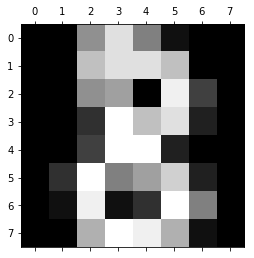

In [17]:
# This is copy-pasted from the example on the scikit-learn website
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape)
import matplotlib.pyplot as plt 
plt.gray() 
plt.matshow(digits.images[8]) 
plt.show() 

Code below. It runs but must be debugged.

In [9]:
batch = 1
batch += 1
print(batch)
batch += 1
print(batch)

2
3


In [10]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.b1 = np.random.normal(size=(1,hidden_size))
        self.w1 = np.random.normal(size=(input_size,hidden_size))
        self.b2 = np.random.normal(size=(1,hidden_size))
        self.w2 = np.random.normal(size=(hidden_size,hidden_size))
        self.b_out = np.random.normal(size=(1,output_size))
        self.w_out = np.random.normal(size=(hidden_size,output_size))

def sigmoid(z):
    return 1/(1+np.exp(-z))
        
def NLLcost(a_out, y):
    return -np.mean(np.sum(y*np.log(a_out) + (1-y)*np.log(1-a_out), 1))
        
def accuracy(a_out, y):
    tests = a_out.argmax(axis=0) == y
    print(tests.sum())

def feedforward(x, y, NN):
    z1 = x.dot(NN.w1) + NN.b1
    a1 = sigmoid(z1)
    z2 = a1.dot(NN.w2) + NN.b2
    a2 = sigmoid(z2)
    z_out = a2.dot(NN.w_out) + NN.b_out
    a_out = sigmoid(z_out)
    cost = NLLcost(a_out, y)
    return a1, a2, a_out, cost

def backprop(x, y, NN, a1, a2, a_out):
    # output parameters
    w_out_grad = a2.transpose().dot(a_out - y)
    b_out_grad = a_out - y
    delta_out = (a_out - y).dot(NN.w_out.transpose())
    # layer 2 parameters
    prime2 = a2 * (1 - a2)
    w2_grad = a1.transpose().dot(prime2 * delta_out)
    b2_grad = (prime2 * delta_out)
    delta2 = (delta_out * prime2).dot(NN.w2.transpose())
    # layer 1 parameters
    prime1 = a1 * (1 - a1)
    w1_grad = x.transpose().dot(prime1 * delta2)
    b1_grad = (prime1 * delta2)
    return w_out_grad, b_out_grad, w2_grad, b2_grad, w1_grad, b1_grad
    
def step(NN, w2_grad, b2_grad, w1_grad, b1_grad, w_out_grad, b_out_grad, lr, batch_size):
    NN.w1 =- (lr / batch_size) * w1_grad
    NN.b1 =- (lr / batch_size) * b1_grad.sum(axis=0)
    NN.w2 =- (lr / batch_size) * w2_grad
    NN.b2 =- (lr / batch_size) * b2_grad.sum(axis=0)
    NN.w_out =- (lr / batch_size) * w_out_grad
    NN.b_out =- (lr / batch_size) * b_out_grad.sum(axis=0)

# Set our learning rate
lr = 0.05
# Initialize a neural network    
MyNeuralNetwork = NeuralNetwork(64, 256, 10)
# Load the data, this time with labels, index 0 is the input, 1 is the output
digits = load_digits(n_class=10, return_X_y=True)
# A sloppy data rescale (16 is the max pixel intensity)
x = digits[0]/16 - 0.5
# Create one-hot vectors for the outputs
y = np.eye(10)[digits[1]]
# We'll do batches of 10... we need to find out the indexes to use
batch_size = 10
batch_pos = list(range(0, digits[0].data.shape[0] - 1, batch_size))
batch_amount = len(batch_pos)
epochs = 5
for ep in range(1, epochs+1):
    batch_num = 1
    for b in batch_pos:
        batch_x = x[b:b+batch_size]
        batch_y = y[b:b+batch_size]
        a1, a2, a_out, cost = feedforward(batch_x, batch_y, MyNeuralNetwork)
        w_out_grad, b_out_grad, w2_grad, b2_grad, w1_grad, b1_grad \
            = backprop(batch_x, batch_y, MyNeuralNetwork, a1, a2, a_out)
        step(MyNeuralNetwork, w2_grad, b2_grad, w1_grad, b1_grad, w_out_grad, b_out_grad, lr, batch_size)
        if batch_num % 25 == 0:
            print("epoch {:3d}, batch {:3d}, lr {:7.5f}, loss {:6.2f}".format(ep, batch_num, lr, cost))
        batch_num += 1
    lr /= 2
    a1, a2, a_out, cost = feedforward(x, y, MyNeuralNetwork)
    accuracy(a_out, y)

epoch   1, batch  25, lr 0.05000, loss   5.06
epoch   1, batch  50, lr 0.05000, loss   4.84
epoch   1, batch  75, lr 0.05000, loss   4.76
epoch   1, batch 100, lr 0.05000, loss   4.65
epoch   1, batch 125, lr 0.05000, loss   4.79
epoch   1, batch 150, lr 0.05000, loss   4.96
epoch   1, batch 175, lr 0.05000, loss   4.79
0
epoch   2, batch  25, lr 0.02500, loss   5.40
epoch   2, batch  50, lr 0.02500, loss   5.36
epoch   2, batch  75, lr 0.02500, loss   5.34
epoch   2, batch 100, lr 0.02500, loss   5.31
epoch   2, batch 125, lr 0.02500, loss   5.40
epoch   2, batch 150, lr 0.02500, loss   5.44
epoch   2, batch 175, lr 0.02500, loss   5.39
0
epoch   3, batch  25, lr 0.01250, loss   5.96
epoch   3, batch  50, lr 0.01250, loss   5.95
epoch   3, batch  75, lr 0.01250, loss   5.94
epoch   3, batch 100, lr 0.01250, loss   5.93
epoch   3, batch 125, lr 0.01250, loss   5.97
epoch   3, batch 150, lr 0.01250, loss   5.98
epoch   3, batch 175, lr 0.01250, loss   5.96
0
epoch   4, batch  25, lr 0.0